In [6]:
import utils
import numpy as np
import matplotlib.pyplot as plt


(train_x, train_y), (test_x, test_y) = utils.processed_data()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 100us/step - loss: 0.3022 - categorical_accuracy: 0.6656 - val_loss: 0.2800 - val_categorical_accuracy: 0.7192
Epoch 2/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.2602 - categorical_accuracy: 0.7641 - val_loss: 0.2424 - val_categorical_accuracy: 0.7656
Epoch 3/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.2257 - categorical_accuracy: 0.7789 - val_loss: 0.2113 - val_categorical_accuracy: 0.7733
Epoch 4/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.1959 - categorical_accuracy: 0.7943 - val_loss: 0.1843 - val_categorical_accuracy: 0.7789
Epoch 5/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.1703 - categorical_accuracy: 0.8090 - val_loss: 0.1607 - val_categorical_accuracy: 0.8139
Epoch 6/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.1478 - catego

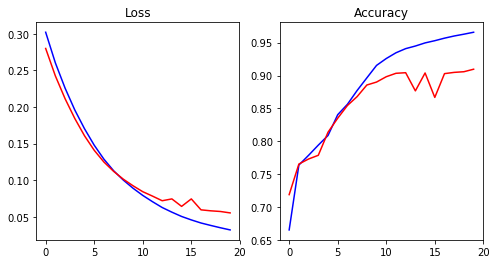

In [34]:
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K


class EuclideanNorm(layers.Layer):
    
    def __init__(
        self,
        num_centroids,
        centroid_initializer="zeros",
        centroid_regularizer=None,
        kwargs={}
    ):
        super(EuclideanNorm, self).__init__(**kwargs)
        self.num_centroids = num_centroids
        self.centroid_initializer = keras.initializers.get(centroid_initializer)
        self.centroid_regularizer = keras.regularizers.get(centroid_regularizer)
        
        
    def build(self, input_shape):
        self.centroids = self.add_weight(
            name="centroids",
            shape=(self.num_centroids, input_shape[1]),
            initializer=self.centroid_initializer,
            regularizer=self.centroid_regularizer,
            trainable=True)
        super(EuclideanNorm, self).build(input_shape)
    
    
    def call(self, x):
        x = K.expand_dims(x, axis=1) - self.centroids
        return K.sqrt(K.sum(K.square(x), axis=-1))
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_centroids)
    

model = keras.Sequential([
    layers.Reshape((28,28,1), input_shape=(28,28)),
    layers.Conv2D(16, (3, 3), strides=(1,1), padding="same"),
    layers.BatchNormalization(scale=False),
    layers.Activation("relu"),
    layers.Conv2D(32, (3, 3), strides=(2,2), padding="same"),
    layers.BatchNormalization(scale=False),
    layers.Activation("relu"),
    layers.Conv2D(64, (3, 3), strides=(2,2), padding="same"),
    layers.BatchNormalization(scale=False),
    layers.Activation("relu"),
    layers.Flatten(),
    layers.Dense(8, activation="relu"),
    EuclideanNorm(10),
    layers.Lambda(lambda x: -x),
    layers.Activation("softmax")
])

model.compile(
    optimizer=keras.optimizers.adam(lr=0.001),
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

# train the model
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=256,
    epochs=20,
    validation_data=(test_x, test_y),
    verbose=1,
    shuffle=True)

# plot the loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Accuracy")
axes[1].plot(history.history["categorical_accuracy"], c="b")
axes[1].plot(history.history["val_categorical_accuracy"], c="r")

success rate: 1.0
success rate: 1.0
success rate: 0.7
success rate: 1.0
success rate: 0.8
success rate: 1.0
success rate: 1.0
success rate: 1.0
success rate: 1.0
success rate: 1.0


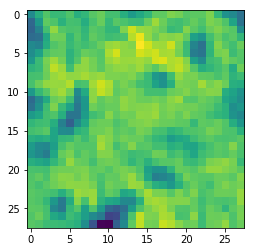

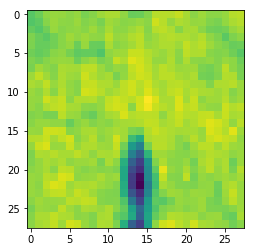

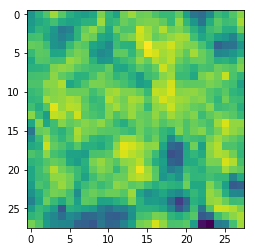

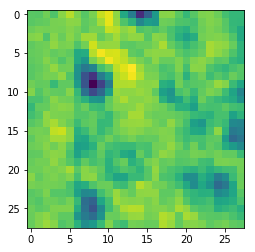

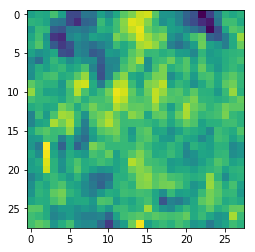

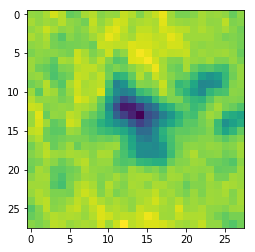

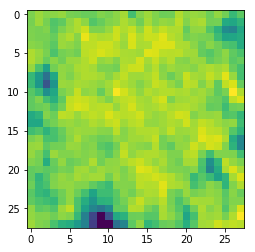

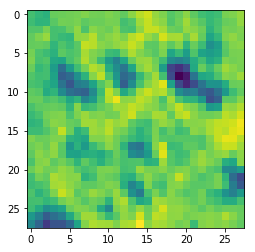

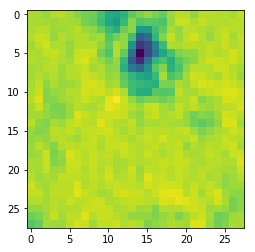

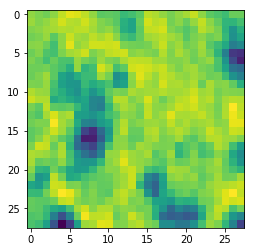

In [30]:
from scipy.ndimage.filters import gaussian_filter


def maximize_output(target_class):
    image = np.random.normal(0.5, 0.1, (10,28,28))
    #centroids = model.layers[-3].get_weights()[0]

    loss = K.sum(model.output[:,target_class])
    grads = K.gradients(loss, model.inputs)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-8)

    iterate = K.function(model.inputs, [loss, grads])

    for i in range(20):
        loss_val, grads_val = iterate([image])
        image += grads_val.reshape(-1,28,28)
        image = gaussian_filter(image, 0.5)

    plt.figure()
    plt.imshow(np.mean(image, axis=0))
    
    return np.mean(np.argmax(model.predict(image), axis=1) == target_class)
    

for i in range(10):
    print("success rate: {}". format(maximize_output(i)))